<center> 
    <h1> MÔN HỌC: XỬ LÝ NGÔN NGỮ TỰ NHIÊN - 7080510 </h1>
    <h2> Đề tài: NGHIÊN CỨU PHÂN LOẠI THƯ RÁC DỰA TRÊN THUẬT TOÁN NAIVE BAYES </h2>
</center>
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<br>

Giảng viên hướng dẫn: Nguyễn Thế Lộc 

Sinh viên thực hiện: 

Họ và tên :	Mã số sv :
1. Nguyễn Thu Thảo: 1921050551
2. Hoàng Thị Mơ: 1921050401
3. Đoàn Đức Tùng: 1921050659

Nhóm: 200



In [2]:
#Thêm thư viện
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split 
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### 1. Đọc dữ liệu

Tập dữ liệu bao gồm 5171 tin nhắn với 4 thuộc tính (unnamed: 0, text, label, label_num),

label và label_num cho biết tin nhắn này thuộc lớp nào:
* 0 : Tin nhắn bình thường - spam
* 1 : Tin nhắn rác - ham

text tập hợp các tin nhắn, dữ liệu này chưa được xử lý.

In [3]:
#Đọc file dữ liệu spam_ham_dataset.csv vào biến data
path='spam_ham_dataset.csv'
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [4]:
# Hiển thị 5 dòng dữ liệu đầu tiên
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
# Hiển thị 5 dòng dữ liệu cuối cùng
data.tail()


,Unnamed: 0,label,text,label_num
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0
5170,4807,spam,Subject: important online banking alert\r\ndea...,1


In [6]:
#Kiểm tra dữ liệu missing trong tập: --> Không có dữ liệu missing
data.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

### 2.TIỀN XỬ LÝ DỮ LIỆU VĂN BẢN
---

Sử dụng thư viện Natural Language Tool Kit (NLTK) thực hiện xử lý các email

In [7]:
#Khai báo sử dụng thư viện NLTK
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print(nltk.__version__)

3.7


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Xóa các cột không cần thiết và đổi tên cột

In [8]:
# Xóa cột Unnamed: 0, label
data = data.drop(labels = ["Unnamed: 0", "label"], axis = 1)

In [9]:
data.head()


,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


### Làm sạch dữ liệu

Xử lý I am - I'm

In [10]:
#Thư viện re — Regular expression operations: thao tác với biểu thức chính quy
import re

#hàm decontracted thực hiện chuyển đổi các phần viết tắt thành câu đầy đủ
def decontracted(st):
    # specific
    st = re.sub(r"won\'t", "will not", st)
    st = re.sub(r"can\'t", "can not", st)
    # general
    st = re.sub(r"n\'t", " not", st)
    st = re.sub(r"\'re", " are", st)
    st = re.sub(r"\'s", " is", st)
    st = re.sub(r"\'d", " would", st)
    st = re.sub(r"\'ll", " will", st)
    st = re.sub(r"\'ve", " have", st)
    st = re.sub(r"\'m", " am", st)
    return st

Loại bỏ liên kết (link), địa chỉ email trong câu

In [11]:
#hàm clear_link thực hiện loại bỏ liên kết (link), địa chỉ email trong câu
def clear_link(st):
    #Remove links/email
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', 
                '', st, flags=re.MULTILINE)
    word = re.sub(r'(@[^\s]*)', "", word)
    #word = re.sub('[\W]', ' ', st)
    return word

Loại bỏ các dấu câu, ký tự đặc biệt trong chuỗi

In [12]:
#Hàm clear_punctuation thực hiện loai bỏ các dấu câu, ký tự đặc biệt trong chuỗi
def clear_punctuation(st):
    word = re.sub(r'[^\w\s]', '',st)
    return word

Loại bỏ các ký tự chỉ để lại các ký tự chữ a-z, A-Z

In [13]:
#Hàm clear_special loại bỏ các ký tự chỉ để lại các ký tự chữ a-z, A-Z
def clear_special(st):
    word = re.sub('[^a-zA-Z]', ' ', st)
    return word

#### Kết hợp các hàm

In [14]:
#Hàm clear_noise kết hợp sử dụng các hàm ở trên để xử lý chuỗi

def clear_noise(word):
    word = word.lower()         # chuyển toàn bộ sang chữ thường để xử lý
    word = decontracted(word)
    word = clear_link(word)
    word = clear_punctuation(word)
    word = clear_special(word)
    return word

#### Loại bỏ stopword

In [15]:
#stopwords là những từ xuất hiện nhiều trong văn bản, nhưng ko có ý nghĩa 
#Load danh sách Stopword trong tiếng anh

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#Hiển thị danh sách các stopwords trong tiếng anh
print('Hiển thị danh sách các stopwords trong tiếng anh:\n',stop)

Hiển thị danh sách các stopwords trong tiếng anh:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', '

In [17]:
#hàm clear_stopwords lọai bỏ các từ stopword trong câu
def clear_stopwords(st):
    word = " ".join(st for st in st.split() if st not in stop)
    return word

Chuẩn hóa từ (Stemming và Lemmatization)


In [18]:
from nltk.stem import WordNetLemmatizer
wn = WordNetLemmatizer()
import string
my_sw = ['rt', 'ht', 'fb', 'amp', 'gt']

def black_txt(token):
  if token == 'u':
    token = 'you'
  return  token not in stop and token not in list(string.punctuation) and token not in my_sw


def fun_stemlem(word):
  list_word_clean = []
  for w1 in word.split(" "):
    if  black_txt(w1.lower()):
      word_lemma =  wn.lemmatize(w1,  pos="v")
      list_word_clean.append(word_lemma)

  #Cleaning, lowering and remove whitespaces
  word = " ".join(list_word_clean)
  return word 

In [19]:
#Ví dụ một tin nhắn trong data:
st1 = data.iloc[2000]['text']
st1

"Subject: mobil chemical - hpl meter # 1256 - expense transport\r\ned - can you help ? i need to know the term of our existing transport expense\r\ndeal with reliant entex to serve the referenced customer . we must have an\r\nexisting contract that we can look up . our existing deal to sell to mobil\r\nexpires october 1 . i am trying to make a two year sales offer beginning\r\noctober 1 . if the transport expires before then , then we ' ll need to call\r\nentex about a transport rate . who is the correct dealmaker to call entex on\r\nthis matter ? ? i ' d be happy to do it , but i ' d be stepping on somebody else ' s\r\nturf .\r\nif the existing rate is indeed 5 cents plus 2 . 02 % fuel , that seems kind of\r\nhigh . it ' s a short haul - according to our field folk , we give the gas to\r\nentex at the la porte city gate , and it goes to the mobil plant at pasadena ,\r\nabout 10 miles away at the most .\r\nany and all help appreciated .\r\nlee\r\nenron north america corp .\r\nfrom : pa

In [20]:
print('1.----------Chuỗi ban đầu------------------------:\n ', st1)
sta = clear_noise(st1)
print('2.----------Chuỗi loại bỏ nhiễu:-----------------:\n',sta)
stb = clear_stopwords(sta)
print('3.----------Chuỗi loại bỏ stopwords--------------:\n',stb)
stc = fun_stemlem(stb)
print('4.--Chuỗi loại xử lý Stemming và Lemmatization---:\n',stc)   

1.----------Chuỗi ban đầu------------------------:
  Subject: mobil chemical - hpl meter # 1256 - expense transport
ed - can you help ? i need to know the term of our existing transport expense
deal with reliant entex to serve the referenced customer . we must have an
existing contract that we can look up . our existing deal to sell to mobil
expires october 1 . i am trying to make a two year sales offer beginning
october 1 . if the transport expires before then , then we ' ll need to call
entex about a transport rate . who is the correct dealmaker to call entex on
this matter ? ? i ' d be happy to do it , but i ' d be stepping on somebody else ' s
turf .
if the existing rate is indeed 5 cents plus 2 . 02 % fuel , that seems kind of
high . it ' s a short haul - according to our field folk , we give the gas to
entex at the la porte city gate , and it goes to the mobil plant at pasadena ,
about 10 miles away at the most .
any and all help appreciated .
lee
enron north america corp .
from 

Xử lý toàn bộ dữ liệu

In [21]:
#Xây dựng hàm prepare_data: để thực hiện tiền xử lý dữ liệu
def prepare_data(word):
    word = clear_noise(word)        #Loại bỏ nhiễu trong các comment
    word = clear_stopwords(word)    #Loại bỏ stopword trong các comment
    word = fun_stemlem(word)        #Chuẩn hóa comment
    return word

In [22]:
#Hiển thị danh sách các từ trước và sau khi tiền xử lý để test
for idx in data[3000:3004].index:
  print(idx, 
        '\n a.Dữ liệu gốc          :', data.iloc[idx]['text'],
        '\n b.Dữ liệu sau chuẩn hóa:',prepare_data(data.iloc[idx]['text']))
  print("************")

3000 
 a.Dữ liệu gốc          : Subject: enron / hpl actuals for november 20 , 2000
teco tap 30 . 000 / enron ; 68 . 542 / hpl gas daily 
 b.Dữ liệu sau chuẩn hóa: subject enron hpl actuals november teco tap enron hpl gas daily
************
3001 
 a.Dữ liệu gốc          : Subject: defs purchase of teco pipeline
effective february 1 , 2001 duke energy field services ( defs ) will begin
operating teco pipeline under the name duke energy guadalupe pipeline inc .
we are attempting to make this transition as seamless as possible with a
minimum of changes .
the only meter number change will be at the el paso field services waha
header . in the past shippers have nominated at 00501723 whereas starting
february lst you will nominate at 8000007 .
for the time being , use the same nomination form you have used in the past .
be sure to include both upstream and downstream contract numbers on your
this form . attached is a file which will list , with a description , all the
meters on the duke ener

In [23]:
#Tạo dataframe data_new, bổ sung thêm field: text_ok là tin nhắn đã được tiền xử lý dữ liệu tương ứng
data_new = data.copy()
data_new['text_ok'] = data['text'].apply(lambda x: prepare_data(x))

In [24]:
# Hiển thị dữ liệu sau khi xử lý
data_new.head(10)

,text,label_num,text_ok
0,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter follow note give ...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom january see attach file hplnol...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho around wonderful...
3,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop windows office cheap main tr...
4,Subject: re : indian springs\r\nthis deal is t...,0,subject indian spring deal book teco pvr reven...
5,Subject: ehronline web address change\r\nthis ...,0,subject ehronline web address change message i...
6,Subject: spring savings certificate - take 30 ...,0,subject spring save certificate take save use ...
7,Subject: looking for medication ? we ` re the ...,1,subject look medication best source difficult ...
8,Subject: noms / actual flow for 2 / 26\r\nwe a...,0,subject noms actual flow agree forward melissa...
9,"Subject: nominations for oct . 21 - 23 , 2000\...",0,subject nominations oct see attach file hplnl ...


### lọc và loại bỏ một số tin nhắn rỗng sau chuẩn hóa:


In [25]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5171 non-null   object
 1   label_num  5171 non-null   int64 
 2   text_ok    5171 non-null   object
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [26]:
#Lọc những comment sau khi xử lý chỉ còn là khoảng trắng
print('Tổng số:',data_new['text_ok'].loc[data_new.text_ok==r''].count())
data_new.loc[data_new.text_ok==r'']

Tổng số: 0


,text,label_num,text_ok


## 3. Phân tích dữ liệu

In [27]:
data_new.describe()

,label_num
count,5171.000000
mean,0.289886
std,0.453753
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Kiểm tra mức độ cân bằng của tập dữ liệu

In [28]:
#Kiểm tra mức độ căn bằng của tập DL
target = data_new['label_num'].value_counts()
target

0    3672
1    1499
Name: label_num, dtype: int64

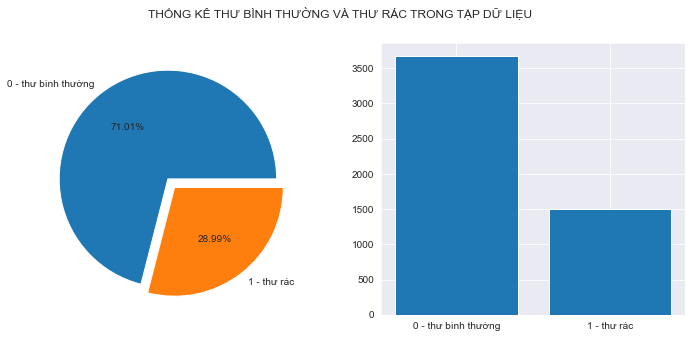

In [29]:
lb =['0 - thư bình thường','1 - thư rác']

f, ax = plt.subplots(1,2, figsize=(12,5))
plt.suptitle('THỐNG KÊ THƯ BÌNH THƯỜNG VÀ THƯ RÁC TRONG TẬP DỮ LIỆU')

ax[0].pie(target,labels=lb, autopct='%.2f%%',explode=[0,0.1])

ax[1].bar(lb, target)

plt.grid(True)
plt.show()


Trong tập dữ liệu có 71.01% là thư bình thường và 28.99% là thư rác

### Quan sát từng tin nhắn ham/spam riêng lẻ

In [30]:
from nltk.probability import FreqDist

In [31]:
spam_messages = data_new[data_new["label_num"] == 1]["text_ok"]
ham_messages = data_new[data_new["label_num"] == 0]["text_ok"]
print("Số tin nhắn rác : ",len(spam_messages))
print("Số tin nhắn bình thường : ",len(ham_messages))

Số tin nhắn rác :  1499
Số tin nhắn bình thường :  3672


In [32]:
#Tin nhắn spam
spam_words = nltk.FreqDist(spam_messages)
spam_words

FreqDist({'subject': 19, 'subject want rolex watch': 3, 'subject week f ree gen erlc vlag ra cover ship send youour product cost prove effectiveness last hurry stop promos': 3, 'subject find school': 3, 'subject smart': 3, 'subject get dell laptop computer free': 2, 'subject injections': 2, 'subject keep memories alive free canon digital camera': 2, 'subject per malboro carton tire pay high tobacco tax guarantee thousands save year premium brand quality price marlboro camel parliament carton save today': 2, 'subject contact info hi notice get response last email use new tool call plaxo update address book information share anyone else need download software register send information please take moment review information click button correct confirm contact information want update address book get plaxo http www plaxo com download thank f': 2, ...})

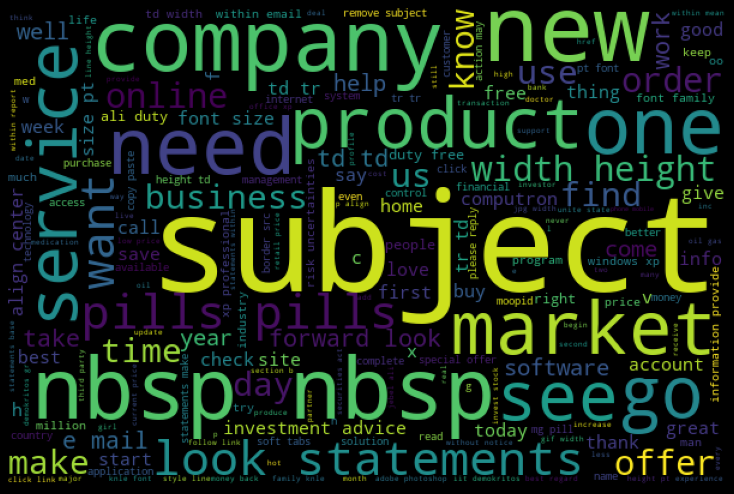

In [33]:
#Word cloud của thư spam
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


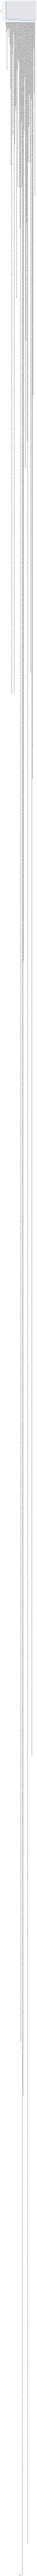

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [34]:

large_words = dict([(k,v) for k,v in spam_words.items() if len(k)>3])
frequency_dist = nltk.FreqDist(large_words)
%matplotlib inline
frequency_dist.plot(50,cumulative=False)

In [35]:
#Tin nhắn bình thường
ham_words = nltk.FreqDist(ham_messages)
ham_words

FreqDist({'subject hpl nom march see attach file hplno xls hplno xls': 31, 'subject hpl nom may see attach file hplno xls hplno xls': 22, 'subject hpl nom april see attach file hplno xls hplno xls': 22, 'subject calpine daily gas nomination ricky archer fuel supply louisiana suite houston texas direct fax calpine daily gas nomination doc': 20, 'subject hpl nom august see attach file hplo xls hplo xls': 17, 'subject hpl nom january see attach file hplnol xls hplnol xls': 15, 'subject hpl nom june see attach file hplo xls hplo xls': 13, 'subject hpl nom sept see attach file hplo xls hplo xls': 12, 'subject hpl nom july see attach file hplo xls hplo xls': 11, 'subject hpl nom february see attach file hplno xls hplno xls': 11, ...})

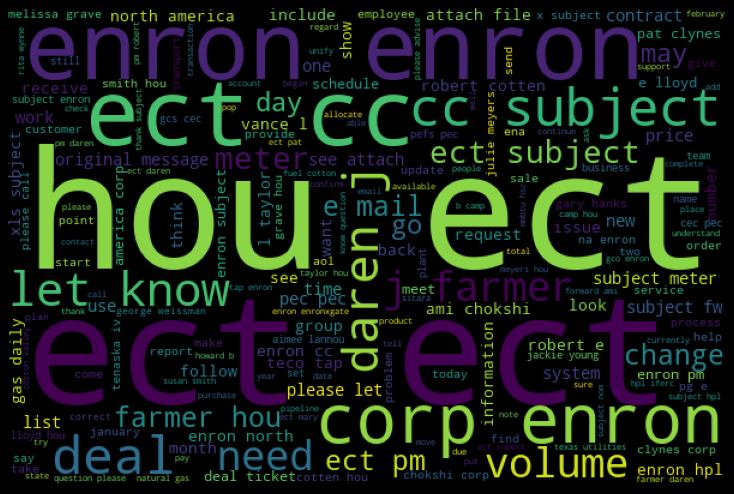

In [36]:
#Word cloud của thư sbình thường
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


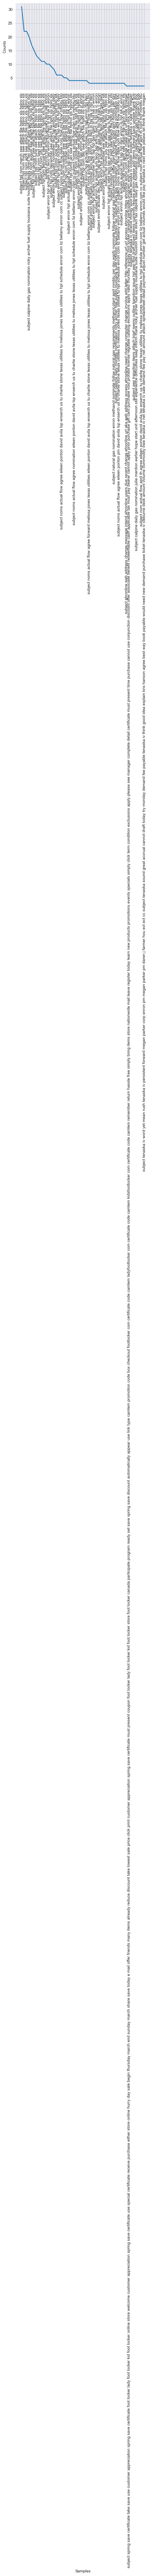

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [37]:
large_words1 = dict([(k,v) for k,v in ham_words.items() if len(k)>3])
frequency_dist1 = nltk.FreqDist(large_words1)
%matplotlib inline
frequency_dist1.plot(50,cumulative=False)

### 4. Phân tách biến độc lập, biến phụ thuộc
---
* Biến độc lập X: Thuộc tính text_ok (nội dung tin nhắn sau khi đã được xử lý)
* Biến phụ thuộc y: label (cho biết tin nhắn đó là spam - ham)

In [38]:
#Biến độc lập X:
X = data_new.loc[:,'text_ok']
X

0       subject enron methanol meter follow note give ...
1       subject hpl nom january see attach file hplnol...
2       subject neon retreat ho ho ho around wonderful...
3       subject photoshop windows office cheap main tr...
4       subject indian spring deal book teco pvr reven...
                              ...                        
5166    subject put ft transport volumes decrease cont...
5167    subject follow noms hpl take extra mmcf weeken...
5168    subject calpine daily gas nomination julie men...
5169    subject industrial worksheets august activity ...
5170    subject important online bank alert dear value...
Name: text_ok, Length: 5171, dtype: object

In [39]:
#Biến phụ thuộc y:
y = data_new.loc[:,'label_num']
y

0       0
1       0
2       0
3       1
4       0
       ..
5166    0
5167    0
5168    0
5169    0
5170    1
Name: label_num, Length: 5171, dtype: int64

#### Tách dữ liệu thành tập Train - Test
---
* Tập Train (80%) sử dụng để huấn luyện model
* Tập Test (20%) sử dụng để kiểm thử độ chính xác của modoe

In [40]:
from sklearn.model_selection import train_test_split
#Tách tập dữ liệu thành Train - Test (tỷ lệ: 0.8 - 0.2)
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42)
print('1.Tập ban đầu:',data_new.shape)
print('-------------------------------')
print('a.Tập Train: ', X_train.shape)
print('b.Tập Test: ', y_test.shape)

1.Tập ban đầu: (5171, 3)
-------------------------------
a.Tập Train:  (4136,)
b.Tập Test:  (1035,)


In [41]:
X_train

5132    subject april activity survey start collect da...
2067    subject message subject hey julie turn high sc...
4716    subject txu fuel sds nomination may attach may...
4710    subject richardson volumes nov dec meter nick ...
2268    subject new era online medical care new era on...
                              ...                        
4426    subject ena sales hpl last legal review contra...
466     subject tenaska iv bob understand sandi handle...
3092    subject broom bristle fly differentiable onoma...
3772    subject calpine daily gas nomination weekend r...
860     subject meter yep right except june please let...
Name: text_ok, Length: 4136, dtype: object

In [42]:
y_train

5132    0
2067    1
4716    0
4710    0
2268    1
       ..
4426    0
466     0
3092    1
3772    0
860     0
Name: label_num, Length: 4136, dtype: int64

### 5. Huấn luyện mô hình

#### Trọng số TF-IDF
----
Viết tắt của thuật ngữ tiếng Anh term frequency – inverse document frequency,tf-idf là trọng số của một từ trong văn bản thu được qua thống kê thể hiện mức độ quan trọng của từ này trong một văn bản, mà bản thân văn bản đang xét nằm trong một tập hợp các văn bản.

**Cách tính trọng số TF-IDF:**
* Tf- term frequency : dùng để ước lượng tần xuất xuất hiện của từ trong văn bản.

    * TF(t, d) = (số lần từ t xuất hiện trong văn bản d) / (tổng số từ trong văn bản d)

* IDF- Inverse Document Frequency: dùng để ước lượng mức độ quan trọng của từ đó như thế nào.

   * IDF(t, D) = log_e( Tổng số văn bản trong tập mẫu D/ Số văn bản có chứa từ t )

In [43]:
# Tính TF-IDF cho tập dữ liệu
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text

#Convert a collection of raw documents to a matrix of TF-IDF features.

vector = TfidfVectorizer(analyzer='word', max_features=15000, stop_words = 'english')

vector.fit(data_new['text_ok'])
X_train_tfidf = vector.transform(X_train)
X_test_tfidf = vector.transform(X_test)

In [44]:
print('1.Train:',X_train_tfidf.shape)
print('2.Test:',X_test_tfidf.shape)

1.Train: (4136, 15000)
2.Test: (1035, 15000)


In [45]:
# Ví dụ 
print(X_train.iloc[10])
print(X_train_tfidf[10].data)
print(X_train_tfidf[10].data.shape)

subject exxonmobil beaumont refinery fuel need fyi need enter sitara remember first eog transport forward lee l papayoti hou ect brian e nichols pm lpapayo ect enron com cc bcc lee l papayoti hou ect subject exxonmobil beaumont refinery fuel need lee fuel gas estimate think need bbtu day fuel gas month april side note bring gas turbine generator sunday morning bring high pressure gas requirements essentially zero zero hydrogen plant stay demand transfer low pressure gas arrangement approximately days brian
[0.17444388 0.14094264 0.08012817 0.09614278 0.06762442 0.10262201
 0.0377277  0.09658665 0.06686597 0.09847461 0.09167203 0.25816933
 0.23201848 0.04935948 0.07505664 0.20984264 0.07054842 0.1367333
 0.18613251 0.08603014 0.05959275 0.08708574 0.27297654 0.15944486
 0.10537046 0.07686173 0.14636944 0.23720031 0.07401031 0.30022654
 0.04724201 0.28188529 0.08138946 0.1367333  0.11870867 0.07421499
 0.04268456 0.15599055 0.0879181  0.07123864 0.05816321 0.04899566
 0.04505852 0.175553

#### Xây dựng mô hình phân lớp với với Thuật toán Naive Bayes

In [46]:
#Sử dụng mô hình Naive Bayes với TF-IDF
from sklearn import naive_bayes

#Khai báo sử dụng model Multinomial Naive bayes:
MultiNB = naive_bayes.MultinomialNB(alpha=1.0)

#huấn luyện mô hình với tập huấn luyện Train
MultiNB.fit(X_train_tfidf,y_train)

#Danh sách các tham số của model:
MultiNB.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [47]:
#Đánh giá độ chính xác của mô hình trên tập huấn luyện
acc_MultiNB = round(MultiNB.score(X_train_tfidf, y_train) * 100, 2)

print('Độ chính xác của mô hình trên tập huấn luyện: ', acc_MultiNB, '%')

Độ chính xác của mô hình trên tập huấn luyện:  97.87 %


In [48]:
from sklearn.metrics import accuracy_score
#Dự đoán và tính đoán độ chính xác của model trên tập Test:
y_pred = MultiNB.predict(X_test_tfidf)

acc1 = round(accuracy_score(y_test, y_pred)*100, 2)
print('1.Độ chính xác của mô hình trên tập Test: ', acc1, '%')

acc2 = accuracy_score(y_test, y_pred, normalize=False)
print('2.Tổng số mẫu dự đoán đúng:', acc2, ' /', len(y_test))
print('3.Tổng số mẫu dự đoán sai:', len(y_test) - acc2, ' /', len(y_test))

1.Độ chính xác của mô hình trên tập Test:  96.81 %
2.Tổng số mẫu dự đoán đúng: 1002  / 1035
3.Tổng số mẫu dự đoán sai: 33  / 1035


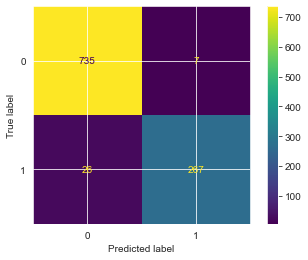

In [49]:
#Hiển thị confusion matrix:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(MultiNB, X_test_tfidf, y_test)  
plt.show()

#### Ví dụ với một tin nhắn mới --> Sử dụng model đã huấn luyện để cho biết tin nhắn này là spam (1) hay ham (0)

In [50]:
dict_text= {'text':['XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL', 
                         'Ok...i am watching here:)',
                         'Is that seriously how you spell his name?',
                         'Thanks for your subscription to Ringtone UK your mobile will be charged å£5/month Please confirm by replying YES or NO. If you reply NO you will not be charged']}
df_text = pd.DataFrame(dict_text)
df_text

,text
0,"XXXMobileMovieClub: To use your credit, click ..."
1,Ok...i am watching here:)
2,Is that seriously how you spell his name?
3,Thanks for your subscription to Ringtone UK yo...


In [51]:
df_text['text_ok']  = df_text['text'].apply(lambda x: prepare_data(x))
df_text

,text,text_ok
0,"XXXMobileMovieClub: To use your credit, click ...",xxxmobilemovieclub use credit click wap link n...
1,Ok...i am watching here:),oki watch
2,Is that seriously how you spell his name?,seriously spell name
3,Thanks for your subscription to Ringtone UK yo...,thank subscription ringtone uk mobile charge m...


In [52]:
X_text = df_text.iloc[:,1]
X_text

0    xxxmobilemovieclub use credit click wap link n...
1                                            oki watch
2                                 seriously spell name
3    thank subscription ringtone uk mobile charge m...
Name: text_ok, dtype: object

In [53]:
X_text_tfidf = vector.transform(X_text)
X_text_tfidf

<4x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [54]:
y_pred_new = MultiNB.predict(X_text_tfidf)
y_pred_new

array([1, 1, 0, 0], dtype=int64)